# Test MCMC Retrieval

This notebook performs and analyzes two test run of the MCMC retrievals. This is to ensure that the retrieval
is tractable and that the chosen parameters are sound.

## Retrieval Setup

In [1]:
%load_ext autoreload
%autoreload 2

from typhon.arts.workspace import Workspace
import atms
import numpy as np
%matplotlib inline
from matplotlib_settings import *

ws = Workspace()
channels = [0,15,16,17,19]

Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so


In [2]:
atms.setup_atmosphere(ws)
atms.setup_sensor(ws, channels)
atms.checks(ws)
ws.yCalc()

ARTS[32223728]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[32223728]: {
ARTS[32223728]: - verbosityInit
ARTS[32223728]: - scat_speciesSet
ARTS[32223728]: - MatrixSet
ARTS[32223728]: - Tensor4SetConstant
ARTS[32223728]: - ArrayOfStringSet
ARTS[32223728]: - Touch
ARTS[32223728]: - FlagOff
ARTS[32223728]: - MatrixSet
ARTS[32223728]: - NumericSet
ARTS[32223728]: - ArrayOfStringSet
ARTS[32223728]: - Tensor3SetConstant
ARTS[32223728]: - Tensor3SetConstant
ARTS[32223728]: - Tensor3SetConstant
ARTS[32223728]: - Tensor3SetConstant
ARTS[32223728]: - Tensor3SetConstant
ARTS[32223728]: - Tensor3SetConstant
ARTS[32223728]: - IndexSet
ARTS[32223728]: - IndexSet
ARTS[32223728]: - IndexSet
ARTS[32223728]: - IndexSet
ARTS[32223728]: - FlagOff
ARTS[32223728]: - output_file_formatSetAscii
ARTS[32223728]: - StringSet
ARTS[32223728]: - IndexSet
ARTS[32223728]: - abs_lineshapeDefine
ARTS[32223728]: - NumericSet
ARTS[32223728]: - NumericSet
ARTS[32223728]: - AgendaSet
ARTS[322237

## A Priori State

The simulations are based on the a priori assumptions, that the profiles of specific humidity, temperature and ozone vary independently and that the relative variations can be described by Log-Gaussian distributions.

In [3]:
t_mean = np.load("data/t_mean.npy").ravel()
q_mean = np.load("data/q_mean.npy").ravel()
qt_mean = np.load("data/qt_mean.npy").ravel()
q_log_mean = np.load("data/q_log_mean.npy").ravel()

In [4]:
t_cov     = np.load("data/t_cov.npy")
q_cov     = np.load("data/q_log_cov.npy")
qt_cov    = np.load("data/qt_cov.npy")

In [5]:
t_cov_inv   = np.linalg.inv(t_cov)
q_cov_inv   = np.linalg.inv(q_cov)
qt_cov_inv  = np.linalg.inv(qt_cov)

## Jumping Functions

The jumping functions are used inside the MCMC iteration and propose new atmospheric states for specific humidity, temperature and ozone, respectively. The proposed states are generated from random walks that use scaled versions of the a priori covariances.

In [42]:
import numpy as np
from typhon.retrieval.mcmc import RandomWalk
c = (2.4 / np.sqrt(q_mean.size)) ** 2
c2 = (0.5 * 2.4 / np.sqrt(qt_mean.size)) ** 2

rw_t   = RandomWalk(c * t_cov)
rw_q   = RandomWalk(c * q_cov)
rw_qt  = RandomWalk(c2 * qt_cov)

def j_t(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_t.step(x)
    ws.t_field.value[:, 0, 0] = x_new[::-1]
    return x_new

def j_q(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_q.step(x)
    q_new = (np.exp(x_new).reshape(q_mean.shape))[::-1]
    q_new = atms.mmr2vmr(ws, q_new, "h2o")
    ws.vmr_field.value[0, :, 0, 0] = q_new
    return x_new

def j_qt(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_qt.step(x)
    q_new = (np.exp(x_new[14::-1]).reshape((15,)))
    q_new = atms.mmr2vmr(ws, q_new, "h2o")
    ws.vmr_field.value[0, :, 0, 0] = q_new
    ws.t_field.value[:, 0, 0] = x_new[:14:-1]
    return x_new

## Temperature 

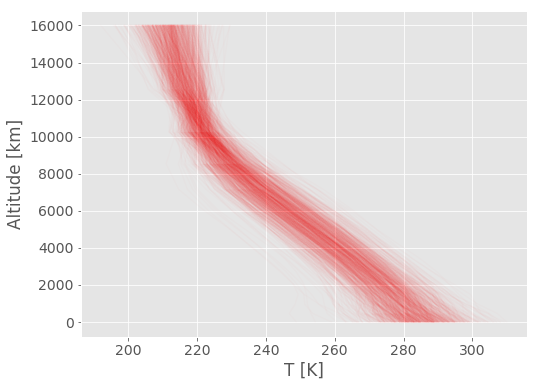

In [43]:
for i in range(1000):
    j_t(ws, t_mean)
    plt.plot(ws.t_field.value.ravel(),
             ws.z_field.value.ravel(),
            c = 'r', alpha = 0.01)
plt.xlabel("T [K]")
plt.ylabel("Altitude [km]")

### Water Vapor

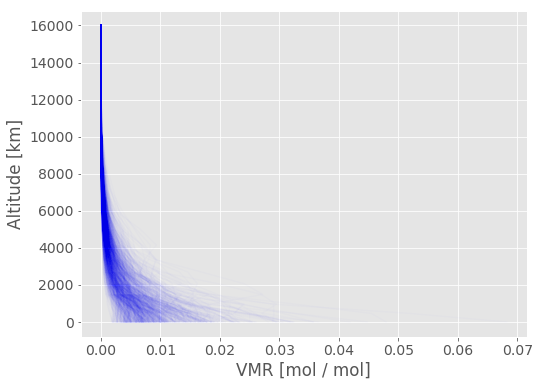

In [44]:
for i in range(1000):
    j_q(ws, q_log_mean) 
    plt.plot(ws.vmr_field.value[0, :, 0, 0].ravel(),
             ws.z_field.value.ravel(),
            c = 'b', alpha = 0.01)
plt.xlabel("VMR [mol / mol]")
plt.ylabel("Altitude [km]")

## A Priori Distributions

These functions return the likelihood (up to an additive constant) of a given state for each of the variables. Note that the states of specific humidity, temperature and ozone are given by the logs of the relative variations. 

In [45]:
def p_a_t(x):
    dx = x - t_mean
    l = - 0.5 * np.dot(dx, np.dot(t_cov_inv, dx))
    return l

def p_a_q(x):
    dx = x - q_log_mean
    l = - 0.5 * np.dot(dx, np.dot(q_cov_inv, dx))
    return l

def p_a_qt(x):
    dx = x - qt_mean
    l = - 0.5 * np.dot(dx, np.dot(qt_cov_inv, dx))
    return l

## Measurement Uncertainty

We assume that uncertainty of the measured brightness temperatures can be described by independent Gaussian error with a standard deviation of $1 K$.

In [46]:
covmat_y = np.diag(np.ones(len(channels)))
covmat_y_inv = np.linalg.inv(covmat_y)

def p_y(y, yf):
    dy = y - yf
    l  = - 0.5 * np.dot(dy, np.dot(covmat_y_inv, dy))
    return l

# Running MCMC


### The Simulated Measurement

For the simulated measurement, we sample a state from the a priori distribution of atmsopheric states and simulate the measured brightness temperatures.

In [53]:
dist = atms.StateDistribution()

# Generate True State
dist.sample(ws)
ws.yCalc()
y_true   = np.copy(ws.y)
q_true  = np.copy(ws.vmr_field.value[0, :, 0, 0].ravel())
t_true  = np.copy(ws.t_field.value[:, 0, 0].ravel())
cwv_true = atms.vmr2cd(ws)
dist.a_priori(ws)

(array([  8.08473991e-03,   7.30145914e-03,   6.01676248e-03,
          4.48967953e-03,   3.32909369e-03,   2.45489321e-03,
          1.77163901e-03,   1.23154249e-03,   8.02342017e-04,
          4.88068856e-04,   2.76837503e-04,   1.32285440e-04,
          4.33038442e-05,   1.08086169e-05,   4.57943111e-06]),
 array([ 285.48313716,  282.26411885,  279.57321176,  276.83634657,
         273.48070648,  269.53279608,  264.97329736,  259.74107238,
         253.68444238,  246.56801493,  238.29440154,  229.51450076,
         221.68151883,  216.90220186,  211.72859046]))

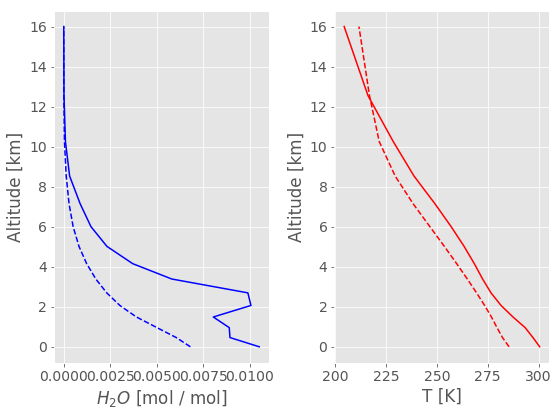

In [54]:
fig, axs = plt.subplots(1,2)
axs[0].plot(q_true,
            ws.z_field.value.ravel() * 1e-3,
            c = 'b')
axs[0].plot(q_mean.ravel()[::-1],
            ws.z_field.value.ravel() * 1e-3,
            c = 'b', ls = '--')
axs[0].set_xlabel("$H_2O$ [mol / mol]")
axs[0].set_ylabel("Altitude [km]")
axs[1].plot(t_true,
            ws.z_field.value.ravel() * 1e-3,
            c = 'r')
axs[1].plot(t_mean.ravel()[::-1],
            ws.z_field.value.ravel() * 1e-3,
            c = 'r', ls = '--')
axs[1].set_xlabel("T [K]")
axs[1].set_ylabel("Altitude [km]")

plt.tight_layout()

A simple heuristic is applied to ensure that reasonable acceptance rates are obtained during the MCMC simulations. After the initial burn-in phase, 1000 simulation steps are performed. If the acceptance rates during this simulation are too low/high that covariance matrices of the corresponding random walks are scaled by a factor 0.1 / 9.0, respectively.

In [55]:
def adapt_covariances(acceptances):
    # q
    if (np.sum(a[:, 0]) / a.shape[0]) < 0.2:
        rw_q.covmat *= 0.3
    if (np.sum(a[:, 0]) / a.shape[0]) > 0.4:
        rw_q.covmat *= 3.0
#    # t 
#    if (np.sum(a[:, 1]) / a.shape[0]) < 0.2:
#        rw_t.covmat *= 0.3
#    if (np.sum(a[:, 1]) / a.shape[0]) > 0.4:
#        rw_t.covmat *= 3.0

### First Simple Test Run

A first test run is performed and all simulation steps are saved and plotted. This is to ensure that the different simulation phases are consistent and a reasonable estimate of the true integrated column water vapor is obtained.

In [56]:
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

n_burn_in = 1000
n_prod    = 5000
drop      = 20

q = np.zeros(q_mean.size)
t = np.zeros(t_mean.size)
qt = np.zeros(qt_mean.size)

# Add Noise
y_true += np.random.randn(*y_true.shape)

mcmc  = MCMC([[qt, p_a_qt, j_qt]], y_true, p_y, [vmr2cd])

qt_0 = dist.sample_factors()
h1, s1, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
h2, s2, _, a = mcmc.run(ws, n_burn_in)
adapt_covariances(a)
h3, s3, _, a = mcmc.run(ws, n_burn_in)
h4, s4, _, a = mcmc.run(ws, n_prod)

-5.68191376357
[-22.57408117]
MCMC Step 0: ar = 0.0
-5.68191376357
[-22.57408117]
-5.68191376357
[-22.57408117]
-5.68191376357
[-22.57408117]
-5.68191376357
[-22.57408117]
-5.68191376357
[-22.57408117]
-5.68191376357
[-22.57408117]
-5.68191376357
[-22.57408117]
-4.99032067447
[-20.99916515]
-4.99032067447
[-20.99916515]
-4.73354447024
[-19.74949188]
MCMC Step 10: ar = [ 0.2]
-4.73354447024
[-19.74949188]
-4.73354447024
[-19.74949188]
-4.73354447024
[-19.74949188]
-4.73354447024
[-19.74949188]
-4.73354447024
[-19.74949188]
-4.73354447024
[-19.74949188]
-4.73354447024
[-19.74949188]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
MCMC Step 20: ar = [ 0.15]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
-1.52981266386
[-20.4491125]
MCMC Ste

-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
MCMC Step 290: ar = [ 0.04827586]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
MCMC Step 300: ar = [ 0.04666667]
-0.471595796972
[-20.85230881]
-0.471595796972
[-20.85230881]
-3.19971562021
[-19.21298642]
-3.19971562021
[-19.21298642]
-3.19971562021
[-19.21298642]
-3.19971562021
[-19.21298642]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
MCMC Step 310: ar = [ 0.0516129]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385
[-20.46593559]
-2.98778763385


-1.40589927229
[-19.359735]
MCMC Step 560: ar = [ 0.05357143]
-1.40589927229
[-19.359735]
-2.93911945926
[-19.92731439]
-2.93911945926
[-19.92731439]
-2.93911945926
[-19.92731439]
-2.93911945926
[-19.92731439]
-2.93911945926
[-19.92731439]
-2.93911945926
[-19.92731439]
-2.93911945926
[-19.92731439]
-2.64734827881
[-20.87808988]
-2.64734827881
[-20.87808988]
MCMC Step 570: ar = [ 0.05614035]
-2.14541718951
[-20.66844693]
-4.85896238601
[-19.39199805]
-4.02926526879
[-18.86322832]
-4.02926526879
[-18.86322832]
-4.02926526879
[-18.86322832]
-4.02926526879
[-18.86322832]
-4.02926526879
[-18.86322832]
-4.02926526879
[-18.86322832]
-4.02926526879
[-18.86322832]
-2.03785906854
[-21.27492434]
MCMC Step 580: ar = [ 0.06206897]
-2.03785906854
[-21.27492434]
-2.03785906854
[-21.27492434]
-2.03785906854
[-21.27492434]
-2.03785906854
[-21.27492434]
-2.03785906854
[-21.27492434]
-2.03785906854
[-21.27492434]
-2.03785906854
[-21.27492434]
-2.63615707548
[-19.63720035]
-2.63615707548
[-19.63720035]
-2

-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
MCMC Step 810: ar = [ 0.06049383]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
MCMC Step 820: ar = [ 0.0597561]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
MCMC Step 830: ar = [ 0.05903614]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]
-1.49418675102
[-18.48610051]

MCMC Step 340: ar = [ 0.05588235]
MCMC Step 350: ar = [ 0.05714286]
MCMC Step 360: ar = [ 0.05555556]
MCMC Step 370: ar = [ 0.05675676]
MCMC Step 380: ar = [ 0.06052632]
MCMC Step 390: ar = [ 0.06153846]
MCMC Step 400: ar = [ 0.06]
MCMC Step 410: ar = [ 0.06097561]
MCMC Step 420: ar = [ 0.06190476]
MCMC Step 430: ar = [ 0.06046512]
MCMC Step 440: ar = [ 0.05909091]
MCMC Step 450: ar = [ 0.05777778]
MCMC Step 460: ar = [ 0.05652174]
MCMC Step 470: ar = [ 0.05531915]
MCMC Step 480: ar = [ 0.05416667]
MCMC Step 490: ar = [ 0.05306122]
MCMC Step 500: ar = [ 0.054]
MCMC Step 510: ar = [ 0.05294118]
MCMC Step 520: ar = [ 0.05192308]
MCMC Step 530: ar = [ 0.05471698]
MCMC Step 540: ar = [ 0.05555556]
MCMC Step 550: ar = [ 0.05636364]
MCMC Step 560: ar = [ 0.05714286]
MCMC Step 570: ar = [ 0.05789474]
MCMC Step 580: ar = [ 0.05689655]
MCMC Step 590: ar = [ 0.0559322]
MCMC Step 600: ar = [ 0.05666667]
MCMC Step 610: ar = [ 0.0557377]
MCMC Step 620: ar = [ 0.05806452]
MCMC Step 630: ar = [ 0.057

MCMC Step 340: ar = [ 0.03823529]
MCMC Step 350: ar = [ 0.04]
MCMC Step 360: ar = [ 0.04166667]
MCMC Step 370: ar = [ 0.04054054]
MCMC Step 380: ar = [ 0.03947368]
MCMC Step 390: ar = [ 0.03846154]
MCMC Step 400: ar = [ 0.0375]
MCMC Step 410: ar = [ 0.03658537]
MCMC Step 420: ar = [ 0.03809524]
MCMC Step 430: ar = [ 0.0372093]
MCMC Step 440: ar = [ 0.03636364]
MCMC Step 450: ar = [ 0.03555556]
MCMC Step 460: ar = [ 0.03478261]
MCMC Step 470: ar = [ 0.03617021]
MCMC Step 480: ar = [ 0.0375]
MCMC Step 490: ar = [ 0.03877551]
MCMC Step 500: ar = [ 0.038]
MCMC Step 510: ar = [ 0.0372549]
MCMC Step 520: ar = [ 0.03653846]
MCMC Step 530: ar = [ 0.03584906]
MCMC Step 540: ar = [ 0.03703704]
MCMC Step 550: ar = [ 0.03636364]
MCMC Step 560: ar = [ 0.0375]
MCMC Step 570: ar = [ 0.04035088]
MCMC Step 580: ar = [ 0.04137931]
MCMC Step 590: ar = [ 0.04237288]
MCMC Step 600: ar = [ 0.04166667]
MCMC Step 610: ar = [ 0.0442623]
MCMC Step 620: ar = [ 0.04354839]
MCMC Step 630: ar = [ 0.04761905]
MCMC S

MCMC Step 2730: ar = [ 0.05421245]
MCMC Step 2740: ar = [ 0.0540146]
MCMC Step 2750: ar = [ 0.05381818]
MCMC Step 2760: ar = [ 0.05362319]
MCMC Step 2770: ar = [ 0.0534296]
MCMC Step 2780: ar = [ 0.05323741]
MCMC Step 2790: ar = [ 0.05340502]
MCMC Step 2800: ar = [ 0.05321429]
MCMC Step 2810: ar = [ 0.05338078]
MCMC Step 2820: ar = [ 0.0535461]
MCMC Step 2830: ar = [ 0.05335689]
MCMC Step 2840: ar = [ 0.05352113]
MCMC Step 2850: ar = [ 0.05333333]
MCMC Step 2860: ar = [ 0.0534965]
MCMC Step 2870: ar = [ 0.05365854]
MCMC Step 2880: ar = [ 0.05381944]
MCMC Step 2890: ar = [ 0.05397924]
MCMC Step 2900: ar = [ 0.0537931]
MCMC Step 2910: ar = [ 0.05360825]
MCMC Step 2920: ar = [ 0.05342466]
MCMC Step 2930: ar = [ 0.05358362]
MCMC Step 2940: ar = [ 0.05340136]
MCMC Step 2950: ar = [ 0.05322034]
MCMC Step 2960: ar = [ 0.05304054]
MCMC Step 2970: ar = [ 0.05319865]
MCMC Step 2980: ar = [ 0.05302013]
MCMC Step 2990: ar = [ 0.05284281]
MCMC Step 3000: ar = [ 0.05266667]
MCMC Step 3010: ar = [ 0.

#### Column Water Vapor

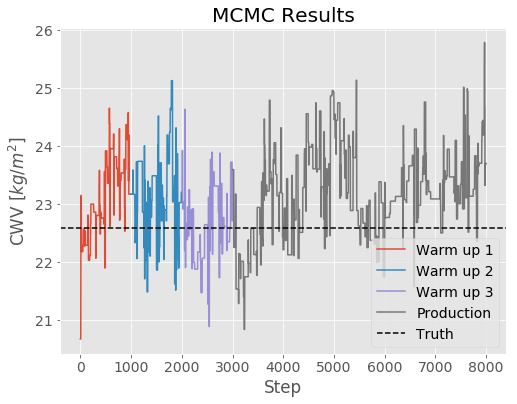

In [57]:
plt.figure()
plt.plot(np.arange(0, 1001), s1, label = 'Warm up 1')
plt.plot(np.arange(0, 1000) + 1001, s2, label = 'Warm up 2')
plt.plot(np.arange(0, 1000) + 2001, s3, label = 'Warm up 3')
plt.plot(np.arange(0, 5000) + 3001, s4, label = 'Production')
plt.axhline(cwv_true, c = 'k', ls = '--', label = 'Truth')

plt.legend()
plt.xlabel("Step")
plt.ylabel("CWV [$kg / m^2$]")
plt.title("MCMC Results")

#### Water Vapor and Temperature Profiles

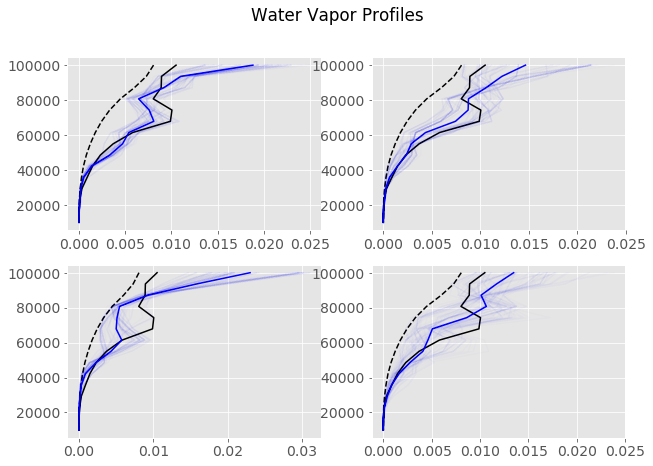

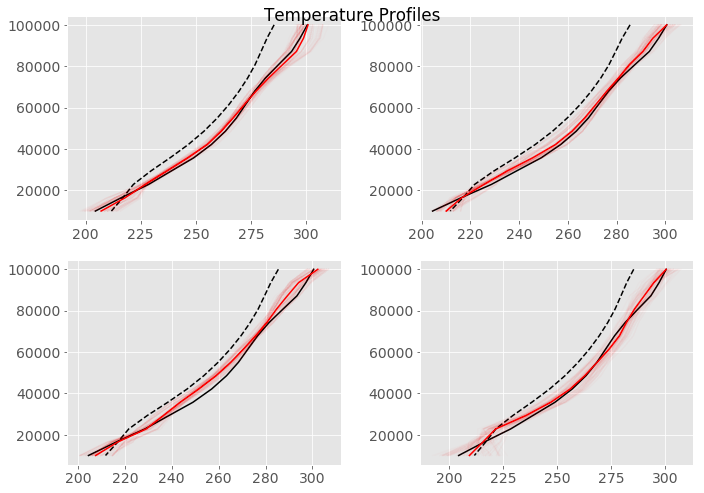

In [58]:
profiles_q = [np.exp(h1[0][:,:15]), np.exp(h2[0][:,:15]), np.exp(h3[0][:,:15]), np.exp(h4[0][:,:15])]
profiles_t = [h1[0][:, 15:], h2[0][:, 15:], h3[0][:, 15:], h4[0][:, 15:]]

f, axs = plt.subplots(2, 2, figsize = (10, 7))
plt.suptitle("Water Vapor Profiles")
axs = axs.ravel()
for i in range(4):
    axs[i].plot(np.exp(dist.q_log_mean)[::-1] * 28.9 / 18.0,
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(q_true, ws.p_grid, c = 'k')
    axs[i].plot(np.mean(profiles_q[i], axis = 0)[::-1] * 28.9 / 18.0,
             ws.p_grid,
             c = 'b')
    for j in range(100):
        k = np.random.randint(0, profiles_q[i].shape[0])
        axs[i].plot(profiles_q[i][k, ::-1] * 28.9 / 18.0,
                 ws.p_grid,
                 c = 'b',
                 alpha = 0.01)
        
f, axs = plt.subplots(2, 2, figsize = (10, 7))
plt.suptitle("Temperature Profiles")
axs = axs.ravel()
for i in range(4):
    axs[i].plot(dist.t_mean[::-1],
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(t_true, ws.p_grid, c = 'k')
    axs[i].plot(np.mean(profiles_t[i], axis = 0)[::-1],
             ws.p_grid,
             c = 'r')
    for j in range(100):
        k = np.random.randint(0, profiles_t[i].shape[0])
        axs[i].plot(profiles_t[i][k, ::-1],
                     ws.p_grid,
                     c = "r",
                     alpha = 0.01)
        
plt.tight_layout()

### A Complete Run

For the production of the retrieval a posteriori distribution, each single retrieval consists of four MCMC simulations with different starting point. Each simulation then consists of three warm-up phase of which the second is used to adapt the covariance matrix of the random walks used to propose new states.

The warm-up phase is then followed by a production phase of 5000 steps.

In [68]:
# Generate True State
dist.sample(ws)
ws.yCalc()
y_true   = np.copy(ws.y)
q_true  = np.copy(ws.vmr_field.value[0, :, 0, 0].ravel())
t_true  = np.copy(ws.t_field.value[:, 0, 0].ravel())
cwv_true = vmr2cd(ws)
dist.a_priori(ws)

(array([  8.08473991e-03,   7.30145914e-03,   6.01676248e-03,
          4.48967953e-03,   3.32909369e-03,   2.45489321e-03,
          1.77163901e-03,   1.23154249e-03,   8.02342017e-04,
          4.88068856e-04,   2.76837503e-04,   1.32285440e-04,
          4.33038442e-05,   1.08086169e-05,   4.57943111e-06]),
 array([ 285.48313716,  282.26411885,  279.57321176,  276.83634657,
         273.48070648,  269.53279608,  264.97329736,  259.74107238,
         253.68444238,  246.56801493,  238.29440154,  229.51450076,
         221.68151883,  216.90220186,  211.72859046]))

In [69]:
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

n_burn_in = 1000
n_prod    = 5000
drop      = 20

q = np.zeros(q_mean.size)
t = np.zeros(t_mean.size)

# Add Noise
y_true += np.random.randn(*y_true.shape)

mcmc  = MCMC([[qt, p_a_qt, j_qt]], y_true, p_y, [vmr2cd])

qt_0 = dist.sample_factors()
_, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
_, _, _, a = mcmc.run(ws, n_burn_in)
#adapt_covariances(a)
_, _, _, a = mcmc.run(ws, n_burn_in)
hist_1, s_1, _, _ = mcmc.run(ws, n_prod)

qt_0 = dist.sample_factors()
_, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
_, _, _, a = mcmc.run(ws, n_burn_in)
#adapt_covariances(a)
_, _, _, a = mcmc.run(ws, n_burn_in)
hist_2, s_2, _, _ = mcmc.run(ws, n_prod)

qt_0 = dist.sample_factors()
_, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
_, _, _, a = mcmc.run(ws, n_burn_in)
#adapt_covariances(a)
_, _, _, a = mcmc.run(ws, n_burn_in)
hist_3, s_3, _, _ = mcmc.run(ws, n_prod)

qt_0 = dist.sample_factors()
_, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
_, _, _, a = mcmc.run(ws, n_burn_in)
#adapt_covariances(a)
_, _, _, a = mcmc.run(ws, n_burn_in)
hist_4, s_4, _, _ = mcmc.run(ws, n_prod)

profiles =  np.stack([hist_1[0],
                      hist_2[0],
                      hist_3[0],
                      hist_4[0]], axis=0)
cwv = np.stack([s_1, s_2, s_3, s_4], axis=0)


-227.346190336
[-17.74316158]
MCMC Step 0: ar = 0.0
-227.346190336
[-17.74316158]
-162.9774262
[-16.27095936]
-162.9774262
[-16.27095936]
-108.366770737
[-16.80150567]
-101.920200299
[-18.32543006]
-101.920200299
[-18.32543006]
-101.920200299
[-18.32543006]
-78.5345263459
[-18.15298431]
-78.5345263459
[-18.15298431]
-78.5345263459
[-18.15298431]
MCMC Step 10: ar = [ 0.4]
-78.5345263459
[-18.15298431]
-78.5345263459
[-18.15298431]
-78.5345263459
[-18.15298431]
-71.6719666024
[-19.42228679]
-71.6719666024
[-19.42228679]
-71.6719666024
[-19.42228679]
-71.6719666024
[-19.42228679]
-75.5621882124
[-17.74066556]
-75.5621882124
[-17.74066556]
-65.5817508936
[-18.29460566]
MCMC Step 20: ar = [ 0.35]
-63.5435972066
[-17.74196589]
-61.5444480445
[-17.29422335]
-61.5444480445
[-17.29422335]
-44.5523114362
[-18.00123997]
-26.7924616144
[-18.26964978]
-25.4442404165
[-18.69943944]
-25.4442404165
[-18.69943944]
-22.8811502366
[-19.20971988]
-22.8811502366
[-19.20971988]
-17.5479468913
[-21.43331042]

-3.94901373388
[-24.71674658]
-3.94901373388
[-24.71674658]
-3.94901373388
[-24.71674658]
-3.94901373388
[-24.71674658]
-4.36029075178
[-23.70776702]
MCMC Step 280: ar = [ 0.17142857]
-6.47006412513
[-21.17819313]
-6.47006412513
[-21.17819313]
-6.47006412513
[-21.17819313]
-8.02924982595
[-20.19575321]
-3.31654355185
[-20.88692154]
-3.31654355185
[-20.88692154]
-3.31654355185
[-20.88692154]
-3.31654355185
[-20.88692154]
-3.31654355185
[-20.88692154]
-3.87641253721
[-20.87085865]
MCMC Step 290: ar = [ 0.17931034]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
-3.87641253721
[-20.87085865]
MCMC Step 300: ar = [ 0.17333333]
-4.90580915641
[-18.94925106]
-4.90580915641
[-18.94925106]
-7.2555975725
[-18.23973888]
-7.2555975725
[-18.23973888]
-7.2555975725
[-18.23973888]
-

-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
MCMC Step 560: ar = [ 0.16428571]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
MCMC Step 570: ar = [ 0.16140351]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
MCMC Step 580: ar = [ 0.15862069]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595]
-3.23672591383
[-14.78012595

-4.15785869162
[-16.66912765]
-4.85476532765
[-16.50160149]
MCMC Step 840: ar = [ 0.13928571]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
MCMC Step 850: ar = [ 0.13882353]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.46069937096
[-17.36319318]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
MCMC Step 860: ar = [ 0.13837209]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757]
-3.25742732322
[-18.16354757

MCMC Step 660: ar = [ 0.11212121]
MCMC Step 670: ar = [ 0.1119403]
MCMC Step 680: ar = [ 0.11029412]
MCMC Step 690: ar = [ 0.11014493]
MCMC Step 700: ar = [ 0.11]
MCMC Step 710: ar = [ 0.11408451]
MCMC Step 720: ar = [ 0.11388889]
MCMC Step 730: ar = [ 0.11506849]
MCMC Step 740: ar = [ 0.11621622]
MCMC Step 750: ar = [ 0.12]
MCMC Step 760: ar = [ 0.11973684]
MCMC Step 770: ar = [ 0.12207792]
MCMC Step 780: ar = [ 0.12307692]
MCMC Step 790: ar = [ 0.12278481]
MCMC Step 800: ar = [ 0.12125]
MCMC Step 810: ar = [ 0.12222222]
MCMC Step 820: ar = [ 0.12317073]
MCMC Step 830: ar = [ 0.12168675]
MCMC Step 840: ar = [ 0.12261905]
MCMC Step 850: ar = [ 0.12235294]
MCMC Step 860: ar = [ 0.12209302]
MCMC Step 870: ar = [ 0.12183908]
MCMC Step 880: ar = [ 0.12272727]
MCMC Step 890: ar = [ 0.12134831]
MCMC Step 900: ar = [ 0.12111111]
MCMC Step 910: ar = [ 0.11978022]
MCMC Step 920: ar = [ 0.11956522]
MCMC Step 930: ar = [ 0.11935484]
MCMC Step 940: ar = [ 0.11808511]
MCMC Step 950: ar = [ 0.118947

MCMC Step 660: ar = [ 0.11212121]
MCMC Step 670: ar = [ 0.1119403]
MCMC Step 680: ar = [ 0.11323529]
MCMC Step 690: ar = [ 0.1115942]
MCMC Step 700: ar = [ 0.11]
MCMC Step 710: ar = [ 0.1084507]
MCMC Step 720: ar = [ 0.10972222]
MCMC Step 730: ar = [ 0.1109589]
MCMC Step 740: ar = [ 0.10945946]
MCMC Step 750: ar = [ 0.11066667]
MCMC Step 760: ar = [ 0.11052632]
MCMC Step 770: ar = [ 0.11168831]
MCMC Step 780: ar = [ 0.11153846]
MCMC Step 790: ar = [ 0.11265823]
MCMC Step 800: ar = [ 0.1125]
MCMC Step 810: ar = [ 0.11234568]
MCMC Step 820: ar = [ 0.11219512]
MCMC Step 830: ar = [ 0.11204819]
MCMC Step 840: ar = [ 0.11190476]
MCMC Step 850: ar = [ 0.11176471]
MCMC Step 860: ar = [ 0.11162791]
MCMC Step 870: ar = [ 0.11494253]
MCMC Step 880: ar = [ 0.11363636]
MCMC Step 890: ar = [ 0.11573034]
MCMC Step 900: ar = [ 0.11666667]
MCMC Step 910: ar = [ 0.11648352]
MCMC Step 920: ar = [ 0.11630435]
MCMC Step 930: ar = [ 0.11505376]
MCMC Step 940: ar = [ 0.11489362]
MCMC Step 950: ar = [ 0.1157

MCMC Step 3070: ar = [ 0.11302932]
MCMC Step 3080: ar = [ 0.11266234]
MCMC Step 3090: ar = [ 0.11229773]
MCMC Step 3100: ar = [ 0.11225806]
MCMC Step 3110: ar = [ 0.11189711]
MCMC Step 3120: ar = [ 0.11217949]
MCMC Step 3130: ar = [ 0.11182109]
MCMC Step 3140: ar = [ 0.11178344]
MCMC Step 3150: ar = [ 0.11174603]
MCMC Step 3160: ar = [ 0.11202532]
MCMC Step 3170: ar = [ 0.11198738]
MCMC Step 3180: ar = [ 0.11194969]
MCMC Step 3190: ar = [ 0.11191223]
MCMC Step 3200: ar = [ 0.1115625]
MCMC Step 3210: ar = [ 0.11183801]
MCMC Step 3220: ar = [ 0.11273292]
MCMC Step 3230: ar = [ 0.1126935]
MCMC Step 3240: ar = [ 0.11265432]
MCMC Step 3250: ar = [ 0.11292308]
MCMC Step 3260: ar = [ 0.11288344]
MCMC Step 3270: ar = [ 0.11314985]
MCMC Step 3280: ar = [ 0.11280488]
MCMC Step 3290: ar = [ 0.11306991]
MCMC Step 3300: ar = [ 0.11333333]
MCMC Step 3310: ar = [ 0.11329305]
MCMC Step 3320: ar = [ 0.11385542]
MCMC Step 3330: ar = [ 0.11381381]
MCMC Step 3340: ar = [ 0.11347305]
MCMC Step 3350: ar = [

-10.5505954722
[-18.26073402]
-10.5505954722
[-18.26073402]
-5.81652186011
[-16.78855876]
-5.81652186011
[-16.78855876]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
MCMC Step 70: ar = [ 0.27142857]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
-3.970883813
[-17.65390582]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
MCMC Step 80: ar = [ 0.25]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-3.77353579027
[-17.4754593]
-4.08993215923
[-16.9366523]
-4.08993215923
[-16.9366523]
MCMC Step 90: ar = [ 0.23333333]
-4.08993215923
[-16.9366523]
-4.08993215923

-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
MCMC Step 320: ar = [ 0.15625]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.02952474765
[-24.17107692]
-4.72024721639
[-25.75338014]
MCMC Step 330: ar = [ 0.15454545]
-4.72024721639
[-25.75338014]
-4.72024721639
[-25.75338014]
-4.72024721639
[-25.75338014]
-4.72024721639
[-25.75338014]
-4.72024721639
[-25.75338014]
-5.55448080931
[-25.99247146]
-5.55448080931
[-25.99247146]
-5.55448080931
[-25.99247146]
-5.55448080931
[-25.99247146]
-5.55448080931
[-25.99247146]
MCMC Step 340: ar = [ 0.15294118]
-5.55448080931
[-25.99247146]
-5.55448080931
[-25.99247146]
-5.55448080931
[-25.99247146]
-5.55448080931
[-25.99247146]
-

-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
MCMC Step 590: ar = [ 0.12542373]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-4.18114969503
[-25.91541106]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
MCMC Step 600: ar = [ 0.125]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-3.93790465554
[-27.10748976]
-4.71565324132
[-25.75451942]
-4.71565324132
[-25.75451942]
-7.6230247773
[-26.93163053]
-7.6230247773
[-26.93163053]
MCMC Step 610: ar = [ 0.12622951]
-7.6230247773
[-26.93163053]
-7.6230247773
[-26.93163053]
-7.6230247773
[-26.93163053]
-7.62302

-6.55798662922
[-17.36347679]
-6.55798662922
[-17.36347679]
-6.55798662922
[-17.36347679]
-6.65172430629
[-17.28369772]
-6.65172430629
[-17.28369772]
-5.68800952155
[-16.6078137]
-5.68800952155
[-16.6078137]
MCMC Step 840: ar = [ 0.13571429]
-5.68800952155
[-16.6078137]
-4.33679731087
[-14.2408239]
-4.33679731087
[-14.2408239]
-4.33679731087
[-14.2408239]
-4.91380876307
[-13.94388317]
-4.91380876307
[-13.94388317]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
MCMC Step 850: ar = [ 0.13764706]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.59650067885
[-12.3668623]
-4.30952214053
[-11.97393055]
-4.30952214053
[-11.97393055]
MCMC Step 860: ar = [ 0.1372093]
-4.30952214053
[-11.97393055]
-4.30952214053
[-11.97393055]
-4.30952214053
[-11.97393055]
-4.30952214053
[-

MCMC Step 630: ar = [ 0.1]
MCMC Step 640: ar = [ 0.1015625]
MCMC Step 650: ar = [ 0.10307692]
MCMC Step 660: ar = [ 0.10454545]
MCMC Step 670: ar = [ 0.10746269]
MCMC Step 680: ar = [ 0.10882353]
MCMC Step 690: ar = [ 0.10869565]
MCMC Step 700: ar = [ 0.10857143]
MCMC Step 710: ar = [ 0.1084507]
MCMC Step 720: ar = [ 0.10833333]
MCMC Step 730: ar = [ 0.10684932]
MCMC Step 740: ar = [ 0.10675676]
MCMC Step 750: ar = [ 0.10666667]
MCMC Step 760: ar = [ 0.10526316]
MCMC Step 770: ar = [ 0.10519481]
MCMC Step 780: ar = [ 0.10769231]
MCMC Step 790: ar = [ 0.10886076]
MCMC Step 800: ar = [ 0.10875]
MCMC Step 810: ar = [ 0.10740741]
MCMC Step 820: ar = [ 0.10731707]
MCMC Step 830: ar = [ 0.10722892]
MCMC Step 840: ar = [ 0.10595238]
MCMC Step 850: ar = [ 0.10588235]
MCMC Step 860: ar = [ 0.10581395]
MCMC Step 870: ar = [ 0.1045977]
MCMC Step 880: ar = [ 0.10340909]
MCMC Step 890: ar = [ 0.10224719]
MCMC Step 900: ar = [ 0.10111111]
MCMC Step 910: ar = [ 0.1]
MCMC Step 920: ar = [ 0.09891304]


MCMC Step 610: ar = [ 0.08032787]
MCMC Step 620: ar = [ 0.08064516]
MCMC Step 630: ar = [ 0.07936508]
MCMC Step 640: ar = [ 0.078125]
MCMC Step 650: ar = [ 0.07846154]
MCMC Step 660: ar = [ 0.07878788]
MCMC Step 670: ar = [ 0.07761194]
MCMC Step 680: ar = [ 0.07794118]
MCMC Step 690: ar = [ 0.07826087]
MCMC Step 700: ar = [ 0.07857143]
MCMC Step 710: ar = [ 0.08028169]
MCMC Step 720: ar = [ 0.07916667]
MCMC Step 730: ar = [ 0.07945205]
MCMC Step 740: ar = [ 0.07972973]
MCMC Step 750: ar = [ 0.07866667]
MCMC Step 760: ar = [ 0.07894737]
MCMC Step 770: ar = [ 0.08051948]
MCMC Step 780: ar = [ 0.07948718]
MCMC Step 790: ar = [ 0.07974684]
MCMC Step 800: ar = [ 0.07875]
MCMC Step 810: ar = [ 0.07777778]
MCMC Step 820: ar = [ 0.07682927]
MCMC Step 830: ar = [ 0.07590361]
MCMC Step 840: ar = [ 0.07619048]
MCMC Step 850: ar = [ 0.07764706]
MCMC Step 860: ar = [ 0.07674419]
MCMC Step 870: ar = [ 0.07586207]
MCMC Step 880: ar = [ 0.07727273]
MCMC Step 890: ar = [ 0.07640449]
MCMC Step 900: ar =

MCMC Step 3020: ar = [ 0.09337748]
MCMC Step 3030: ar = [ 0.09372937]
MCMC Step 3040: ar = [ 0.09375]
MCMC Step 3050: ar = [ 0.09377049]
MCMC Step 3060: ar = [ 0.09411765]
MCMC Step 3070: ar = [ 0.09413681]
MCMC Step 3080: ar = [ 0.09448052]
MCMC Step 3090: ar = [ 0.09417476]
MCMC Step 3100: ar = [ 0.09451613]
MCMC Step 3110: ar = [ 0.09485531]
MCMC Step 3120: ar = [ 0.09455128]
MCMC Step 3130: ar = [ 0.09488818]
MCMC Step 3140: ar = [ 0.09458599]
MCMC Step 3150: ar = [ 0.09428571]
MCMC Step 3160: ar = [ 0.0943038]
MCMC Step 3170: ar = [ 0.09463722]
MCMC Step 3180: ar = [ 0.09465409]
MCMC Step 3190: ar = [ 0.09435737]
MCMC Step 3200: ar = [ 0.0940625]
MCMC Step 3210: ar = [ 0.09501558]
MCMC Step 3220: ar = [ 0.09503106]
MCMC Step 3230: ar = [ 0.09473684]
MCMC Step 3240: ar = [ 0.09475309]
MCMC Step 3250: ar = [ 0.09446154]
MCMC Step 3260: ar = [ 0.09447853]
MCMC Step 3270: ar = [ 0.09480122]
MCMC Step 3280: ar = [ 0.0945122]
MCMC Step 3290: ar = [ 0.09544073]
MCMC Step 3300: ar = [ 0.0

-32.07073631
[-10.13797234]
-32.07073631
[-10.13797234]
-32.07073631
[-10.13797234]
-32.8406632984
[-9.6599678]
MCMC Step 40: ar = [ 0.325]
-32.8406632984
[-9.6599678]
-23.3372741237
[-10.27295837]
-22.4426915919
[-11.26374675]
-12.2130248535
[-11.68065261]
-12.2130248535
[-11.68065261]
-12.2130248535
[-11.68065261]
-12.2130248535
[-11.68065261]
-12.2130248535
[-11.68065261]
-12.2130248535
[-11.68065261]
-10.0656064408
[-14.22283653]
MCMC Step 50: ar = [ 0.34]
-10.0656064408
[-14.22283653]
-8.26939333145
[-16.46356655]
-8.26939333145
[-16.46356655]
-8.26939333145
[-16.46356655]
-8.26939333145
[-16.46356655]
-5.12951750207
[-17.4695313]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
MCMC Step 60: ar = [ 0.33333333]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.10567045636
[-18.5717186]
-4.1

-3.16514126057
[-16.36114389]
-4.5548247963
[-17.64854311]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
MCMC Step 320: ar = [ 0.175]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
MCMC Step 330: ar = [ 0.16969697]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-3.78146890497
[-17.93613121]
-4.20017782465
[-17.80796787]
MCMC Step 340: ar = [ 0.16764706]
-4.20017782465
[-17.80796787]
-4.20017782465
[-17.80796787]
-4.20017782465
[-17.80796787]
-4.20017782465
[-17.80796787]
-4.20017782465
[-17.80796787]
-4.2

-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
MCMC Step 590: ar = [ 0.13050847]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-2.95648115669
[-15.12281588]
-6.67603077788
[-14.00941208]
MCMC Step 600: ar = [ 0.13]
-6.67603077788
[-14.00941208]
-6.67603077788
[-14.00941208]
-6.67603077788
[-14.00941208]
-6.67603077788
[-14.00941208]
-6.67603077788
[-14.00941208]
-6.67603077788
[-14.00941208]
-6.67603077788
[-14.00941208]
-4.65302618749
[-17.12194988]
-4.65302618749
[-17.12194988]
-4.65302618749
[-17.12194988]
MCMC Step 610: ar = [ 0.1295082]
-4.65

-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
MCMC Step 850: ar = [ 0.12117647]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
MCMC Step 860: ar = [ 0.11976744]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]
MCMC Step 870: ar = [ 0.1183908]
-2.50118203873
[-12.63711956]
-2.50118203873
[-12.63711956]

MCMC Step 670: ar = [ 0.12089552]
MCMC Step 680: ar = [ 0.12205882]
MCMC Step 690: ar = [ 0.12173913]
MCMC Step 700: ar = [ 0.12142857]
MCMC Step 710: ar = [ 0.12112676]
MCMC Step 720: ar = [ 0.12083333]
MCMC Step 730: ar = [ 0.11917808]
MCMC Step 740: ar = [ 0.12027027]
MCMC Step 750: ar = [ 0.11866667]
MCMC Step 760: ar = [ 0.11710526]
MCMC Step 770: ar = [ 0.11558442]
MCMC Step 780: ar = [ 0.11410256]
MCMC Step 790: ar = [ 0.11265823]
MCMC Step 800: ar = [ 0.11125]
MCMC Step 810: ar = [ 0.10987654]
MCMC Step 820: ar = [ 0.11097561]
MCMC Step 830: ar = [ 0.10963855]
MCMC Step 840: ar = [ 0.10833333]
MCMC Step 850: ar = [ 0.10705882]
MCMC Step 860: ar = [ 0.10697674]
MCMC Step 870: ar = [ 0.10574713]
MCMC Step 880: ar = [ 0.10568182]
MCMC Step 890: ar = [ 0.10561798]
MCMC Step 900: ar = [ 0.10444444]
MCMC Step 910: ar = [ 0.1043956]
MCMC Step 920: ar = [ 0.10434783]
MCMC Step 930: ar = [ 0.10537634]
MCMC Step 940: ar = [ 0.10638298]
MCMC Step 950: ar = [ 0.10736842]
MCMC Step 960: ar 

MCMC Step 680: ar = [ 0.13823529]
MCMC Step 690: ar = [ 0.13623188]
MCMC Step 700: ar = [ 0.13428571]
MCMC Step 710: ar = [ 0.13239437]
MCMC Step 720: ar = [ 0.13055556]
MCMC Step 730: ar = [ 0.13013699]
MCMC Step 740: ar = [ 0.12972973]
MCMC Step 750: ar = [ 0.128]
MCMC Step 760: ar = [ 0.12894737]
MCMC Step 770: ar = [ 0.12987013]
MCMC Step 780: ar = [ 0.12820513]
MCMC Step 790: ar = [ 0.12658228]
MCMC Step 800: ar = [ 0.12625]
MCMC Step 810: ar = [ 0.12469136]
MCMC Step 820: ar = [ 0.12317073]
MCMC Step 830: ar = [ 0.12289157]
MCMC Step 840: ar = [ 0.12142857]
MCMC Step 850: ar = [ 0.12235294]
MCMC Step 860: ar = [ 0.12209302]
MCMC Step 870: ar = [ 0.12298851]
MCMC Step 880: ar = [ 0.12272727]
MCMC Step 890: ar = [ 0.12359551]
MCMC Step 900: ar = [ 0.12555556]
MCMC Step 910: ar = [ 0.12527473]
MCMC Step 920: ar = [ 0.12717391]
MCMC Step 930: ar = [ 0.12580645]
MCMC Step 940: ar = [ 0.12446809]
MCMC Step 950: ar = [ 0.12526316]
MCMC Step 960: ar = [ 0.125]
MCMC Step 970: ar = [ 0.124

MCMC Step 3070: ar = [ 0.12084691]
MCMC Step 3080: ar = [ 0.12045455]
MCMC Step 3090: ar = [ 0.12038835]
MCMC Step 3100: ar = [ 0.12032258]
MCMC Step 3110: ar = [ 0.12057878]
MCMC Step 3120: ar = [ 0.12051282]
MCMC Step 3130: ar = [ 0.12108626]
MCMC Step 3140: ar = [ 0.12133758]
MCMC Step 3150: ar = [ 0.12190476]
MCMC Step 3160: ar = [ 0.1221519]
MCMC Step 3170: ar = [ 0.12176656]
MCMC Step 3180: ar = [ 0.12138365]
MCMC Step 3190: ar = [ 0.12100313]
MCMC Step 3200: ar = [ 0.1209375]
MCMC Step 3210: ar = [ 0.12087227]
MCMC Step 3220: ar = [ 0.12049689]
MCMC Step 3230: ar = [ 0.12012384]
MCMC Step 3240: ar = [ 0.12067901]
MCMC Step 3250: ar = [ 0.12092308]
MCMC Step 3260: ar = [ 0.1208589]
MCMC Step 3270: ar = [ 0.12079511]
MCMC Step 3280: ar = [ 0.12103659]
MCMC Step 3290: ar = [ 0.12066869]
MCMC Step 3300: ar = [ 0.12090909]
MCMC Step 3310: ar = [ 0.12054381]
MCMC Step 3320: ar = [ 0.12048193]
MCMC Step 3330: ar = [ 0.12012012]
MCMC Step 3340: ar = [ 0.11976048]
MCMC Step 3350: ar = [ 

[-32.88857531]
-6.72576261642
[-32.88857531]
MCMC Step 50: ar = [ 0.32]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
MCMC Step 60: ar = [ 0.26666667]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
MCMC Step 70: ar = [ 0.22857143]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.72576261642
[-32.88857531]
-6.55499815323
[-30.14036852]
-2.7506420603
[-30.318

-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
MCMC Step 310: ar = [ 0.15806452]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-3.53002145678
[-15.91639676]
-4.76662857494
[-15.25573459]
-4.76662857494
[-15.25573459]
-4.76662857494
[-15.25573459]
MCMC Step 320: ar = [ 0.15625]
-4.76662857494
[-15.25573459]
-4.76662857494
[-15.25573459]
-4.76662857494
[-15.25573459]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
MCMC Step 330: ar = [ 0.15454545]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
-3.70442713177
[-14.99461767]
-

-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
MCMC Step 590: ar = [ 0.13728814]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
MCMC Step 600: ar = [ 0.135]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-5.03246144601
[-19.49925834]
-4.68932330024
[-19.53387939]
-4.68932330024
[-19.53387939]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
MCMC Step 610: ar = [ 0.13606557]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
-4.0024960537
[-20.76176528]
-4.0024960537

-6.09839411758
[-21.88371509]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
MCMC Step 880: ar = [ 0.12045455]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
MCMC Step 890: ar = [ 0.11910112]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
MCMC Step 900: ar = [ 0.11777778]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385]
-3.08908712203
[-21.40374385

MCMC Step 30: ar = [ 0.]
MCMC Step 40: ar = [ 0.025]
MCMC Step 50: ar = [ 0.06]
MCMC Step 60: ar = [ 0.05]
MCMC Step 70: ar = [ 0.04285714]
MCMC Step 80: ar = [ 0.0625]
MCMC Step 90: ar = [ 0.05555556]
MCMC Step 100: ar = [ 0.06]
MCMC Step 110: ar = [ 0.06363636]
MCMC Step 120: ar = [ 0.06666667]
MCMC Step 130: ar = [ 0.07692308]
MCMC Step 140: ar = [ 0.07142857]
MCMC Step 150: ar = [ 0.08666667]
MCMC Step 160: ar = [ 0.0875]
MCMC Step 170: ar = [ 0.08235294]
MCMC Step 180: ar = [ 0.07777778]
MCMC Step 190: ar = [ 0.07894737]
MCMC Step 200: ar = [ 0.075]
MCMC Step 210: ar = [ 0.07142857]
MCMC Step 220: ar = [ 0.07727273]
MCMC Step 230: ar = [ 0.0826087]
MCMC Step 240: ar = [ 0.08333333]
MCMC Step 250: ar = [ 0.08]
MCMC Step 260: ar = [ 0.08846154]
MCMC Step 270: ar = [ 0.1037037]
MCMC Step 280: ar = [ 0.11071429]
MCMC Step 290: ar = [ 0.10689655]
MCMC Step 300: ar = [ 0.10333333]
MCMC Step 310: ar = [ 0.10645161]
MCMC Step 320: ar = [ 0.109375]
MCMC Step 330: ar = [ 0.10909091]
MCMC St

MCMC Step 1250: ar = [ 0.1264]
MCMC Step 1260: ar = [ 0.12619048]
MCMC Step 1270: ar = [ 0.12519685]
MCMC Step 1280: ar = [ 0.12421875]
MCMC Step 1290: ar = [ 0.12325581]
MCMC Step 1300: ar = [ 0.12307692]
MCMC Step 1310: ar = [ 0.12290076]
MCMC Step 1320: ar = [ 0.1219697]
MCMC Step 1330: ar = [ 0.12180451]
MCMC Step 1340: ar = [ 0.12089552]
MCMC Step 1350: ar = [ 0.12074074]
MCMC Step 1360: ar = [ 0.12205882]
MCMC Step 1370: ar = [ 0.12262774]
MCMC Step 1380: ar = [ 0.12173913]
MCMC Step 1390: ar = [ 0.12230216]
MCMC Step 1400: ar = [ 0.12285714]
MCMC Step 1410: ar = [ 0.12269504]
MCMC Step 1420: ar = [ 0.12253521]
MCMC Step 1430: ar = [ 0.12237762]
MCMC Step 1440: ar = [ 0.12152778]
MCMC Step 1450: ar = [ 0.12137931]
MCMC Step 1460: ar = [ 0.12191781]
MCMC Step 1470: ar = [ 0.12380952]
MCMC Step 1480: ar = [ 0.12297297]
MCMC Step 1490: ar = [ 0.12348993]
MCMC Step 1500: ar = [ 0.124]
MCMC Step 1510: ar = [ 0.12450331]
MCMC Step 1520: ar = [ 0.12368421]
MCMC Step 1530: ar = [ 0.12287

MCMC Step 3660: ar = [ 0.11748634]
MCMC Step 3670: ar = [ 0.11771117]
MCMC Step 3680: ar = [ 0.1173913]
MCMC Step 3690: ar = [ 0.11707317]
MCMC Step 3700: ar = [ 0.11702703]
MCMC Step 3710: ar = [ 0.11671159]
MCMC Step 3720: ar = [ 0.11639785]
MCMC Step 3730: ar = [ 0.11662198]
MCMC Step 3740: ar = [ 0.1171123]
MCMC Step 3750: ar = [ 0.1176]
MCMC Step 3760: ar = [ 0.11781915]
MCMC Step 3770: ar = [ 0.11777188]
MCMC Step 3780: ar = [ 0.11798942]
MCMC Step 3790: ar = [ 0.1176781]
MCMC Step 3800: ar = [ 0.11789474]
MCMC Step 3810: ar = [ 0.11784777]
MCMC Step 3820: ar = [ 0.11753927]
MCMC Step 3830: ar = [ 0.11749347]
MCMC Step 3840: ar = [ 0.11744792]
MCMC Step 3850: ar = [ 0.1174026]
MCMC Step 3860: ar = [ 0.11735751]
MCMC Step 3870: ar = [ 0.11782946]
MCMC Step 3880: ar = [ 0.11778351]
MCMC Step 3890: ar = [ 0.11773779]
MCMC Step 3900: ar = [ 0.11769231]
MCMC Step 3910: ar = [ 0.11815857]
MCMC Step 3920: ar = [ 0.11785714]
MCMC Step 3930: ar = [ 0.11755725]
MCMC Step 3940: ar = [ 0.117

In [29]:
j_t(ws, t_0)

array([ 226.87049172,  220.55387881,  208.63174311,  210.10997005,
        217.19875   ,  226.32934389,  234.19040812,  240.0918244 ,
        245.11390848,  249.83077005,  254.41835098,  257.87597262,
        259.33368053,  261.27270446,  265.29056342])

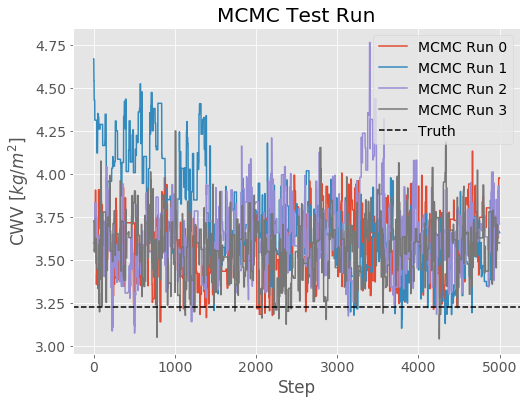

In [70]:
plt.figure()
for i in range(4):
    plt.plot(cwv[i,:,0],label= "MCMC Run " + str(i))
plt.gca().axhline(cwv_true, label="Truth", c='k', ls='--') 
plt.title("MCMC Test Run")
plt.xlabel("Step")
plt.ylabel("CWV $[kg/m^2]$")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (30,) and (15,)

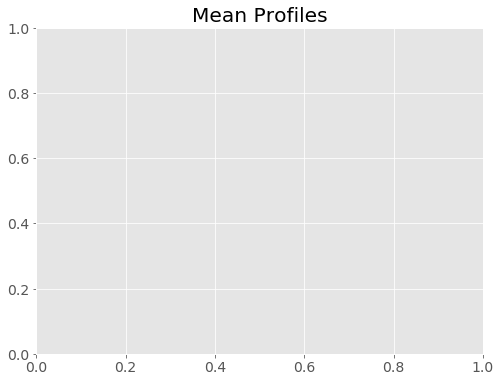

In [71]:
plt.figure()
plt.title("Mean Profiles")
for i in range(4):
    
    plt.plot(atms.mmr2vmr(ws, np.mean(profiles[i,:,:], axis=0, keepdims=True).ravel()[::-1], "h2o"),
             ws.z_field.value[:, 0, 0].ravel() * 1e-3,
             label= "MCMC Run " + str(i))
    
plt.plot(q_true.ravel(),
         ws.z_field.value.ravel() * 1e-3,
         c='b', ls="--", label="Perturbed")
plt.plot(q_mean.ravel()[::-1],
         ws.z_field.value.ravel() * 1e-3,
         c='r', ls="--", label="A Priori")
plt.xlabel("$H_2O$ [mol / mol]")
plt.ylabel("Altitude [km]")
plt.legend()

In [28]:
q_true

array([  5.01530495e-03,   5.64885602e-03,   5.93788403e-03,
         5.78790005e-03,   6.20342621e-03,   5.26910173e-03,
         4.34573016e-03,   2.48025874e-03,   1.81255866e-03,
         1.18721543e-03,   6.12481835e-04,   2.95184797e-04,
         3.13625925e-04,   2.55191796e-04,   1.92042388e-04,
         1.23657440e-04,   6.74589240e-05,   5.28980750e-05,
         4.31347533e-05,   3.60007918e-05,   3.04238814e-05,
         2.35150150e-05,   1.70020107e-05,   1.37951723e-05,
         7.85296615e-06,   5.57374652e-06,   4.73619769e-06])

IndexError: index 1 is out of bounds for axis 0 with size 1

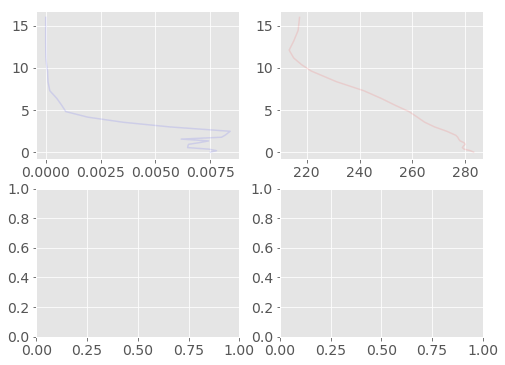

In [22]:
f, axs = plt.subplots(2, 2)
for i in range(1000):
    dist.sample(ws)
    axs[0,0].plot(ws.vmr_field.value[0, :, 0, 0],
                  ws.z_field.value.ravel() * 1e-3,
                  c = 'b', alpha = 0.1)
    axs[0,1].plot(ws.t_field.value.ravel(),
                  ws.z_field.value.ravel() * 1e-3,
                  c = 'r', alpha = 0.1)
    axs[1,0].plot(ws.vmr_field.value[1, :, 0, 0],
                  ws.z_field.value.ravel() * 1e-3,
                  c = 'b', alpha = 0.1)
    
axs[0,0].set_xlabel("$H_2O$ [mol / mol]")
axs[0,0].set_ylabel("Altitude [km]")
axs[0,1].set_xlabel("T [K]")
axs[0,1].set_ylabel("Altitude [km]")
axs[1,0].set_xlabel("$O_3$ [mol / mol]")
axs[1,0].set_ylabel("Altitude [km]")
axs[1,1].set_visible(False)

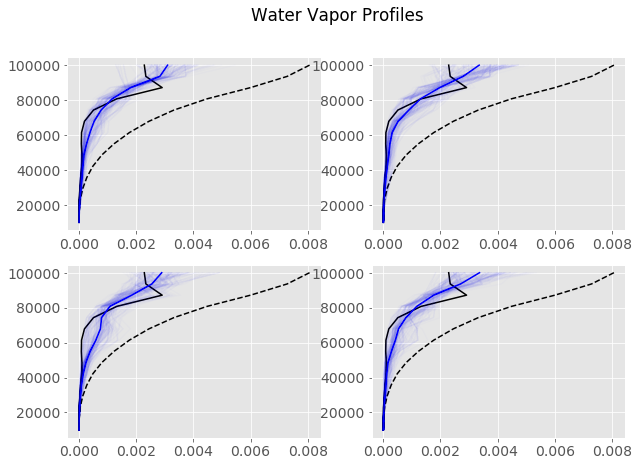

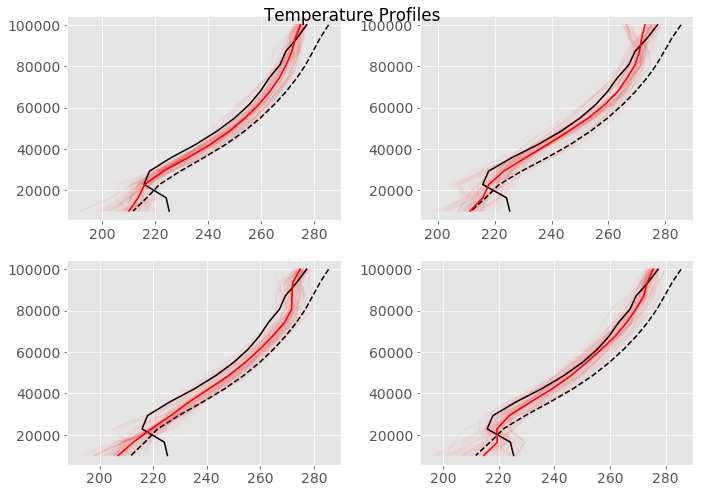

In [73]:
profiles_q = [np.exp(profiles[0, :, :15]),
              np.exp(profiles[1, :, :15]),
              np.exp(profiles[2, :, :15]),
              np.exp(profiles[3, :, :15])]
profiles_t = [profiles[0, :n_prod, 15:],
              profiles[1, :, 15:],
              profiles[2, :, 15:],
              profiles[3, :, 15:]]

f, axs = plt.subplots(2, 2, figsize = (10, 7))
plt.suptitle("Water Vapor Profiles")
axs = axs.ravel()
for i in range(4):
    axs[i].plot(np.exp(dist.q_log_mean)[::-1] * 28.9 / 18.0,
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(q_true, ws.p_grid, c = 'k')
    axs[i].plot(np.mean(profiles_q[i], axis = 0)[::-1] * 28.9 / 18.0,
             ws.p_grid,
             c = 'b')
    for j in range(200):
        k = np.random.randint(0, profiles_q[i].shape[0])
        axs[i].plot(profiles_q[i][k, ::-1] * 28.9 / 18.0,
                 ws.p_grid,
                 c = 'b',
                 alpha = 0.01)
        
f, axs = plt.subplots(2, 2, figsize = (10, 7))
plt.suptitle("Temperature Profiles")
axs = axs.ravel()
for i in range(4):
    axs[i].plot(dist.t_mean[::-1],
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(t_true, ws.p_grid, c = 'k')
    axs[i].plot(np.mean(profiles_t[i], axis = 0)[::-1],
             ws.p_grid,
             c = 'r')
    for j in range(200):
        k = np.random.randint(0, profiles_t[i].shape[0])
        axs[i].plot(profiles_t[i][k, ::-1],
                     ws.p_grid,
                     c = "r",
                     alpha = 0.01)
        
plt.tight_layout()

In [65]:
profiles_q[2].shape[0]

0